# Results

## Imports

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torchvision.models import googlenet
import math
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
import pandas as pd
import re
import os
import random

In [ ]:
# Only if you are on the drive
from google.colab import drive

# Use drive.mount with force_remount=True
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
# Change this path
# Path to your ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/ML Project 2 :)/data (2).zip'

# Extract to a working directory
extract_path = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Define the final transformation pipeline with normalization (optional)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for ResNet
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats to use pretrained weights
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

# Load the datasets again using the final transformation
train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(extract_path, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Best model

In [ ]:
best_googlenet = googlenet(weights="IMAGENET1K_V1")
best_googlenet.fc = nn.Linear(best_googlenet.fc.in_features, 2)
# Change this path if necessary
best_googlenet.load_state_dict(torch.load('/GoogLeNet_trial_1_best.pth', weights_only=True))

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 142MB/s]


<All keys matched successfully>

## Utility functions

In [ ]:
def predict_and_save_results(model, dataloader, output_file, device):
    """
    Evaluate the model on a dataset and save all predictions (correct and incorrect)
    to a text file at the specified path with the file names, indices, true labels,
    predicted labels, and correctness.

    Args:
        model: The trained PyTorch model.
        dataloader: DataLoader for the dataset (training or validation).
        output_file: Path to the output text file.
        device: The device to run the model on (CPU or GPU).
    """
    # Ensure the directory for the output file exists
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Access dataset attributes
    dataset = dataloader.dataset
    if hasattr(dataset, 'samples'):
        file_paths, labels = zip(*dataset.samples)  # Get file paths and labels
    else:
        raise AttributeError("Dataset must have a 'samples' attribute (e.g., from ImageFolder).")

    predictions = []  # Store all predictions

    # Evaluate the model
    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Get predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and correctness
            for batch_idx in range(inputs.size(0)):
                global_idx = idx * dataloader.batch_size + batch_idx  # Compute the global index
                file_name = os.path.basename(file_paths[global_idx])
                correct = preds[batch_idx] == targets[batch_idx]  # Check if prediction is correct

                predictions.append((global_idx, file_name, targets[batch_idx].item(), preds[batch_idx].item(), int(correct)))

    # Write all predictions to the output file
    with open(output_file, 'w') as f:
        f.write("Index,FileName,TrueLabel,PredictedLabel,Correct\n")
        for idx, file_name, true_label, predicted_label, correct in predictions:
            f.write(f"{idx},{file_name},{true_label},{predicted_label},{correct}\n")

    print(f"All predictions saved to {output_file}")

In [ ]:
def evaluate_model_metrics(model, device, criterion, dataloader):
    """
    Evaluates the model on a dataset and computes accuracy, F1-score, AUC, and average loss.

    Args:
        model (torch.nn.Module): The model to evaluate.
        device (torch.device): Device to run the evaluation on (CPU or GPU).
        criterion (torch.nn.Module): Loss function.
        dataloader (torch.utils.data.DataLoader): DataLoader for the evaluation dataset.

    Returns:
        dict: A dictionary containing accuracy, F1-score, AUC (ROC), and average loss.
    """
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    all_labels = []
    all_predictions = []
    all_probs = []  # For storing probabilities for AUC calculation
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, predicted = torch.max(probs, 1)    # Get the class with the highest probability

            # Track total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store labels and predictions for metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming binary classification; probs[:, 1] is for the positive class

    # Accuracy
    accuracy = correct / total

    # F1-Score
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    # AUC (Area Under the Curve)
    try:
        auc = roc_auc_score(all_labels, all_probs)  # For binary classification
    except ValueError:
        auc = None  # AUC is not defined for single-class predictions

    # Average loss
    avg_loss = total_loss / len(dataloader)

    return {
        "accuracy": accuracy * 100,  # Percentage
        "f1_score": f1,
        "auc": auc,
        "average_loss": avg_loss
    }



In [ ]:
def plot_average_roc(models, val_loader, device, labels):
    """
    Plots the ROC curve for multiple models and their average.

    Args:
        models (list of torch.nn.Module): List of trained models.
        val_loader (DataLoader): DataLoader for the validation set.
        device (torch.device): Device to use (CPU or GPU).
        labels (list of str): Names of the models for legend labeling.
    """
    all_fpr = np.linspace(0, 1, 100)  # Common FPR axis for interpolation
    tpr_list = []  # Store TPR values for each model's interpolated curve
    auc_list = []  # Store AUC values for each model

    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        model.eval()
        true_labels = []
        pred_probs = []

        # Disable gradient computation during evaluation
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                probabilities = outputs[:, 1]  # Use logits for positive class

                # Append true labels and predicted probabilities
                true_labels.extend(labels.cpu().numpy())
                pred_probs.extend(probabilities.cpu().numpy())

        # Calculate ROC curve metrics
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)

        # Interpolate TPR to common FPR axis
        interpolated_tpr = np.interp(all_fpr, fpr, tpr)
        tpr_list.append(interpolated_tpr)

        # Plot individual model's ROC curve in light grey
        plt.plot(fpr, tpr, color='lightgrey', lw=1, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

    # Compute the average TPR
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot the average ROC curve in blue
    plt.plot(all_fpr, mean_tpr, color='blue', lw=2, label=f"Average (AUC = {mean_auc:.2f})")

    # Add baseline
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier (AUC = 0.5)")

    # Add labels, title, and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Average ROC Curve Across Models")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [ ]:
def calculate_rates_by_wall(model, dataloader, device, loss_fn, show_recall=False):
    """
    Calculates per-wall performance metrics, including accuracy, F1-score, recall (optional), and loss contribution.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): DataLoader containing the evaluation dataset.
        device (torch.device): The device to perform computations on (e.g., "cuda" or "cpu").
        loss_fn (torch.nn.Module): The loss function used for evaluation.
        show_recall (bool, optional): Whether to include recall in the output. Defaults to False.

    Returns:
        pandas.DataFrame: A DataFrame containing the metrics for each wall, including:
            - "Wall": Wall identifier.
            - "Num Samples": Number of samples belonging to the wall.
            - "TP Rate": True positive rate for the wall.
            - "FP Rate": False positive rate for the wall.
            - "FN Rate": False negative rate for the wall.
            - "TN Rate": True negative rate for the wall.
            - "Loss": Average loss for the wall.
            - "F1 Score": F1-score for the wall.
            - "Accuracy": Accuracy for the wall.
            - "Percentage Contribution to Global Loss": Contribution of the wall's loss to the total loss.
            - "Recall" (if show_recall=True): Recall for the wall.

    Raises:
        AttributeError: If the dataset in the dataloader does not have the "samples" attribute.

    Notes:
        - Assumes the dataset filenames follow a pattern that includes the wall identifier, e.g., "Wall_<number>_".
        - The function is optimized for binary classification.
    """
    model.to(device)
    model.eval()  # Set model to evaluation mode

    results = {}  # To store results per wall number

    dataset = dataloader.dataset
    if not hasattr(dataset, "samples"):
        raise AttributeError("Dataset must have 'samples' attribute (e.g., from ImageFolder).")
    file_paths, true_labels = zip(*dataset.samples)

    all_preds = []
    all_labels = []
    total_loss = 0
    num_samples = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Get predictions
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * len(labels)
            num_samples += len(labels)

            _, preds = torch.max(outputs, 1)

            batch_start = batch_idx * dataloader.batch_size
            batch_end = batch_start + len(labels)
            batch_file_paths = file_paths[batch_start:batch_end]

            for i, file_path in enumerate(batch_file_paths):
                match = re.search(r"Wall_(\d+)_", file_path)
                if not match:
                    continue
                wall_number = match.group(1)

                if wall_number not in results:
                    results[wall_number] = {
                        "TP": 0, "FP": 0, "FN": 0, "TN": 0, "total": 0,
                        "pred_logits": [], "true_labels": [], "loss_sum": 0
                    }

                true_label = labels[i].item()
                pred_label = preds[i].item()

                results[wall_number]["total"] += 1
                results[wall_number]["pred_logits"].append(outputs[i].cpu())
                results[wall_number]["true_labels"].append(true_label)

                results[wall_number]["loss_sum"] += loss_fn(outputs[i].unsqueeze(0), labels[i].unsqueeze(0)).item()

                if true_label == 1:
                    if pred_label == 1:
                        results[wall_number]["TP"] += 1
                    else:
                        results[wall_number]["FN"] += 1
                else:
                    if pred_label == 1:
                        results[wall_number]["FP"] += 1
                    else:
                        results[wall_number]["TN"] += 1

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    data = []
    for wall, counts in results.items():
        total = counts["total"]
        tp = counts["TP"]
        fp = counts["FP"]
        fn = counts["FN"]
        tn = counts["TN"]

        wall_logits = torch.stack(counts["pred_logits"])
        wall_labels = torch.tensor(counts["true_labels"], dtype=torch.long)

        accuracy = (tp + tn) / total if total > 0 else np.NaN
        f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else np.NaN
        loss = loss_fn(wall_logits, wall_labels).item() if total > 0 else np.NaN

        percentage_contribution = (counts["loss_sum"] / total_loss) * 100 if total_loss > 0 else np.NaN

        recall = tp / (tp + fn) if (tp + fn) > 0 else np.NaN

        row = {
            "Wall": wall,
            "Num Samples": total,  # Number of samples for each wall
            "TP Rate": tp / total if total > 0 else np.NaN,
            "FP Rate": fp / total if total > 0 else np.NaN,
            "FN Rate": fn / total if total > 0 else np.NaN,
            "TN Rate": tn / total if total > 0 else np.NaN,
            "Loss": loss,
            "F1 Score": f1,
            "Accuracy": accuracy,
            "% Contribution to Global Loss": percentage_contribution
        }

        if show_recall:
            row["Recall"] = recall

        data.append(row)

    df = pd.DataFrame(data).sort_values(by="Wall")


    return df


In [ ]:
def display_wall_images(dataset, original_path, model, device, wall_number, num_samples=20):
    """
    Display random Wall images of the specified wall number from the dataset
    with ground truth and predicted labels. Misclassified images are highlighted
    with a red thin box for FN and an orange thin box for FP.

    Args:
        dataset: The dataset to load images from.
        original_path: Path to the dataset containing images.
        model: The trained PyTorch model.
        device: The device to run the model on (CPU or GPU).
        wall_number: The wall number to filter images (e.g., 6 for "Wall_6").
        num_samples: Number of images to display.
    """
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    classes = dataset.classes
    wall_images = []
    image_paths = []
    ground_truth_labels = []

    # Search for Wall images with the specified wall number in dataset folders
    wall_identifier = f"Wall_{wall_number}_"
    for label in classes:
        class_folder = os.path.join(original_path, label)
        image_files = os.listdir(class_folder)

        for image_file in image_files:
            if wall_identifier in image_file:
                image_path = os.path.join(class_folder, image_file)
                original_image = Image.open(image_path)
                wall_images.append(original_image)
                image_paths.append(image_path)
                ground_truth_labels.append(label)

    print(f"Found {len(wall_images)} images for Wall {wall_number}.")

    # Randomly select `num_samples` images (or fewer if not enough available)
    num_total_samples = min(num_samples, len(wall_images))
    selected_indices = random.sample(range(len(wall_images)), num_total_samples)

    selected_images = [wall_images[i] for i in selected_indices]
    selected_paths = [image_paths[i] for i in selected_indices]
    selected_labels = [ground_truth_labels[i] for i in selected_indices]

    # Get model predictions for the selected images
    predictions = []
    with torch.no_grad():
        for img_path in selected_paths:
            image = Image.open(img_path).convert("RGB")
            transform = dataset.transform  # Apply same transformations used in training
            img_tensor = transform(image).unsqueeze(0).to(device)  # Prepare batch dimension
            output = model(img_tensor)
            _, pred_label = torch.max(output, 1)
            predictions.append(dataset.classes[pred_label.item()])

    # Display the selected images in a grid
    plt.figure(figsize=(12, 6))

    for i in range(num_total_samples):
        img = selected_images[i].copy()  # Copy original image to draw rectangle

        # Check if the image is misclassified
        if selected_labels[i] != predictions[i]:
            draw = ImageDraw.Draw(img)
            width, height = img.size
            box_thickness = 5


            if predictions[i]=="Cracked" and selected_labels[i]=="Clean":
                draw.rectangle([0, 0, width-1, height-1], outline='orange', width=box_thickness)

            elif selected_labels[i]=="Cracked" and predictions[i]=="Clean":
                draw.rectangle([0, 0, width-1, height-1], outline='red', width=box_thickness)

        plt.subplot(2, 10, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"GT: {selected_labels[i]}\nPred: {predictions[i]}")

    plt.tight_layout()
    plt.show()

### XAI functions

In [ ]:
def gradient(
    x: torch.Tensor,
    model: torch.nn.Module,
    target: int,
) -> np.ndarray:
    """
    Computes the gradient of the target output with respect to the input.

    Args:
        x (torch.Tensor): Input tensor of shape (B, C, W, H).
        model (torch.nn.Module): The model for which gradients are computed.
        target (int): Target class index for which the gradient is calculated.

    Returns:
        np.ndarray: Attribution map of shape (B, W, H), averaged over channels.
    """

    # Ensure gradients are cleared
    if x.grad is not None:
        x.grad.zero_()  # Reset the gradients

    # Enable gradients
    x.requires_grad = True

    # Compute the gradient of the output with respect to the input
    # Forward pass
    output = model(x) # Shape: (B, num_classes) ( , 1000)

    # Select the target output for which gradient is computed
    target_output = output[:, target]  # Shape: (B,)

    # Compute gradients with respect to input
    target_output.backward(torch.ones_like(target_output))

    # Get the gradients and average over channels
    grads = x.grad  # Shape: (B, C, W, H)
    attribution = grads.mean(dim=1).detach().cpu().numpy()  # Averaging over channels

    return attribution


def inputxgradient(
    x: torch.Tensor,
    model: torch.nn.Module,
    target: int,
) -> np.ndarray:
    """
    Computes Input × Gradient for the target output with respect to the input.

    Args:
        x (torch.Tensor): Input tensor of shape (B, C, W, H).
        model (torch.nn.Module): The model for which gradients are computed.
        target (int): Target class index for which the gradients are calculated.

    Returns:
        np.ndarray: Attribution map of shape (B, W, H), averaged over channels.
    """

    # Ensure gradients are cleared
    if x.grad is not None:
        x.grad.zero_()  # Reset the gradients
    # Enable gradients

    x.requires_grad = True

    # Compute the gradient of the output with respect to the input
    # Forward pass
    output = model(x) # Shape: (B, num_classes) ( , 1000)

    # Select the target output for which gradient is computed
    target_output = output[:, target]  # Shape: (B,)

    # Compute gradients with respect to input
    target_output.backward(torch.ones_like(target_output))

    # Get gradients and compute Input × Gradient
    grads = x.grad  # Shape: (B, C, W, H)
    input_grad = x * grads  # Element-wise multiplication
    attribution = input_grad.mean(dim=1).detach().cpu().numpy()

    return attribution


def occlusion(
    x: torch.Tensor,
    model: torch.nn.Module,
    baseline: torch.Tensor,
    w: int = 1,
) -> np.ndarray:
    """
    Occlusion method for feature attribution.

    Args:
    - x: Input tensor, shape (B, C, W, H)
    - model: The model to explain
    - target: Target output dimension to explain
    - baseline: Baseline tensor, shape (C, w, w)
    - w: Occlusion window size (default 1) - !! w must be a multiple of the image size (usually 256) !!

    Returns:
    - Attribution map of shape (B, W, H)
    """
    # Initialize attribution map
    B, C, W, H = x.shape
    attribution = torch.zeros(B, W, H, device=x.device)  # Shape: (B, W, H)

    # Precompute the original model output for the input
    with torch.no_grad():
        pred = model(x).argmax(dim=1)
        original_output = model(x)[:,pred]  # Shape: (B,)

    # Iterate over each patch
    for i in range(0, W, w):
        for j in range(0, H, w):
            # Create a copy of the input and replace the patch with the baseline
            x_occluded = x.clone()
            x_occluded[:, :, i:i + w, j:j + w] = baseline[:, :, :w, :w]

            # Compute the model output for the occluded input
            with torch.no_grad():
                occluded_output = model(x_occluded)[:,pred]  # Shape: (B,)


            # Compute the change in output due to occlusion
            delta = original_output - occluded_output  # Shape: (B,)
            delta = delta.view(B, 1, 1)  # Reshape for broadcasting

            # Assign the delta to the corresponding patch in the attribution map
            attribution[:, i:i + w, j:j + w] += delta

    # Convert the attribution map to numpy format
    attribution = attribution.detach().cpu().numpy()  # Shape: (B, W, H)

    return attribution

In [ ]:
def plot_prediction(method, model, original_image, img_tensor, wall_number, pred_label, gt_label, w, output_dir, save=False):
    """
    Visualizes the prediction and corresponding feature attributions for a given method.

    Args:
        method (str): The feature attribution method to use. Supported options: "gradient", "inputxgradient", "occlusion".
        model (torch.nn.Module): The trained model used for predictions and attributions.
        original_image (np.ndarray): The original image in NumPy format (used for visualization).
        img_tensor (torch.Tensor): The input image tensor of shape (1, C, W, H).
        wall_number (int): Identifier for the wall corresponding to the input image.
        pred_label (int): The predicted class index (0 or 1).
        gt_label (int): The ground truth class index (0 or 1).
        w (int): Window size used for the "occlusion" method.
        output_dir (str): Directory path for saving the plot (if `save=True`).
        save (bool, optional): Whether to save the plot to `output_dir`. Defaults to False.

    Raises:
        ValueError: If an unsupported attribution method is provided.

    Notes:
        - The method computes feature attributions using the specified approach and visualizes them alongside the input image.
        - For "gradient" and "inputxgradient", attributions are computed per pixel. For "occlusion", attributions are computed for regions.

    Returns:
        None: Displays the visualization and optionally saves it to a file.

    Visualization:
        - Displays two panels:
            1. The original input image with a title indicating the wall number.
            2. The attribution map overlayed using a diverging colormap ("RdBu_r").
        - The figure's title includes the ground truth and predicted labels (converted to "Cracked" or "Clean").
    """
      # Compute attributions
    if method == 'gradient':
        attributions = gradient(img_tensor, model, pred_label)
    elif method == 'inputxgradient':
        attributions = inputxgradient(img_tensor, model, pred_label)
    elif method == 'occlusion':
        baseline = torch.zeros_like(img_tensor)
        attributions = occlusion(img_tensor, model, baseline=baseline, w=w)
    else:
        raise ValueError(f"Unsupported method: {method}")

    if pred_label == 1:
        pred_label = "Cracked"
    else:
        pred_label = "Clean"

    if gt_label == 1:
        gt_label = "Cracked"
    else:
        gt_label = "Clean"

    # Visualize results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Set a title for the whole figure
    fig.suptitle(f"Ground Truth: {gt_label}, Prediction: {pred_label}", fontsize=16)

    # Input Image
    ax[0].imshow(original_image)
    ax[0].set_title(f"Input Image, Wall Number {wall_number}")
    ax[0].axis("off")

    # Attributions
    ax[1].imshow(attributions[0], cmap="RdBu_r", vmin=-0.1, vmax=0.1)
    ax[1].set_title(f"{method.capitalize()} Attributions")
    ax[1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle

    plt.show()

In [ ]:
def visualize_wall_images(dataset, original_path, model, device, wall_number, method='gradient', w=1, save=False):
    """
    Visualizes gradient-based or occlusion-based attributions for all images
    matching a specified wall number from the dataset.

    Args:
        dataset: The dataset to load images from.
        original_path: Path to the dataset containing images.
        model: Pre-trained CNN model.
        device: Device to run computations ('cuda' or 'cpu').
        wall_number: The wall number to filter images (e.g., 6 for "Wall_6").
        method: Visualization method ('gradient', 'inputxgradient', or 'occlusion').
        w: Patch size (w x w) for occlusion method.
        save: Whether to save the visualizations as images.
    """
    # Ensure the model is in evaluation mode
    model.eval()
    model.to(device)

    # Search for Wall images with the specified wall number
    wall_identifier = f"Wall_{wall_number}_"
    wall_images = []
    image_paths = []
    ground_truth_labels = []

    for label in dataset.classes:
        class_folder = os.path.join(original_path, label)
        if not os.path.exists(class_folder):
            continue

        image_files = os.listdir(class_folder)
        for image_file in image_files:
            if wall_identifier in image_file:
                image_path = os.path.join(class_folder, image_file)
                wall_images.append(Image.open(image_path))
                image_paths.append(image_path)
                ground_truth_labels.append(label)

    if not wall_images:
        print(f"No images found for Wall {wall_number}.")
        return

    print(f"Found {len(wall_images)} images for Wall {wall_number}.")

    # Prepare output directory if saving is enabled
    if save:
        output_dir = os.path.join("visualizations", f"Wall_{wall_number}")
        os.makedirs(output_dir, exist_ok=True)

    i = 0
    j = 0
    k = 0
    l = 0

    # Apply the specified visualization method to each image
    for idx, (img, img_path, gt_label) in enumerate(zip(wall_images, image_paths, ground_truth_labels)):
        # Transform image for the model
        img_tensor = dataset.transform(img).unsqueeze(0).to(device)  # Add batch dimension

        # Predict the label
        with torch.no_grad():
            output = model(img_tensor)
            pred_label = output.argmax(dim=1).item()

        if gt_label == 'Cracked':
            gt_label = 1
        else:
            gt_label = 0

        original_image = np.array(img)
        if original_image.max() > 1:  # Normalize if in [0, 255]
            original_image = original_image / 255.0

        # Only plot one TP, TN, FN, and FP

        # True Positive
        if pred_label == gt_label and pred_label == 1 and i == 0:
            plot_prediction(method, model, original_image, img_tensor, wall_number, pred_label, gt_label, w, output_dir=None, save=False)
            i = 1
        # True Negative
        elif pred_label == gt_label and pred_label == 0 and j == 0:
            plot_prediction(method, model, original_image, img_tensor, wall_number, pred_label, gt_label, w, output_dir=None, save=False)
            j = 1
        # False Positive
        elif pred_label != gt_label and pred_label == 0 and k == 0:
            plot_prediction(method, model, original_image, img_tensor, wall_number, pred_label, gt_label, w, output_dir=None, save=False)
            k = 1
        # False Negative
        elif pred_label != gt_label and pred_label == 1 and l in {0, 1, 2, 3, 4}:
            plot_prediction(method, model, original_image, img_tensor, wall_number, pred_label, gt_label, w, output_dir=None, save=False)
            l += 1

        if i+j+k+l == 7:
            break

    print(f"Visualization for Wall {wall_number} completed.")

## Results on each set

In [ ]:
predict_and_save_results(best_googlenet, train_loader, '/content/drive/MyDrive/ML Project 2 :)/Final_predictions/training_set.txt', device)
predict_and_save_results(best_googlenet, val_loader, '/content/drive/MyDrive/ML Project 2 :)/Final_predictions/validation_set.txt', device)
predict_and_save_results(best_googlenet, test_loader, '/content/drive/MyDrive/ML Project 2 :)/Final_predictions/test_set.txt', device)

All predictions saved to /content/drive/MyDrive/ML Project 2 :)/Final_predictions/training_set.txt
All predictions saved to /content/drive/MyDrive/ML Project 2 :)/Final_predictions/validation_set.txt
All predictions saved to /content/drive/MyDrive/ML Project 2 :)/Final_predictions/test_set.txt


In [ ]:
evaluate_model_metrics(best_googlenet, device, criterion, train_loader)

{'accuracy': 94.36514475121184,
 'f1_score': 0.9355631553385156,
 'auc': 0.9654845224488057,
 'average_loss': 0.1620425621724601}

In [ ]:
evaluate_model_metrics(best_googlenet, device, criterion, val_loader)

{'accuracy': 93.96919651141214,
 'f1_score': 0.9354829633969381,
 'auc': 0.9296570375075714,
 'average_loss': 0.1765644262503012}

In [ ]:
evaluate_model_metrics(best_googlenet, device, criterion, test_loader)

{'accuracy': 91.55011655011654,
 'f1_score': 0.890610889921001,
 'auc': 0.7991351447477475,
 'average_loss': 0.3472737048165769}

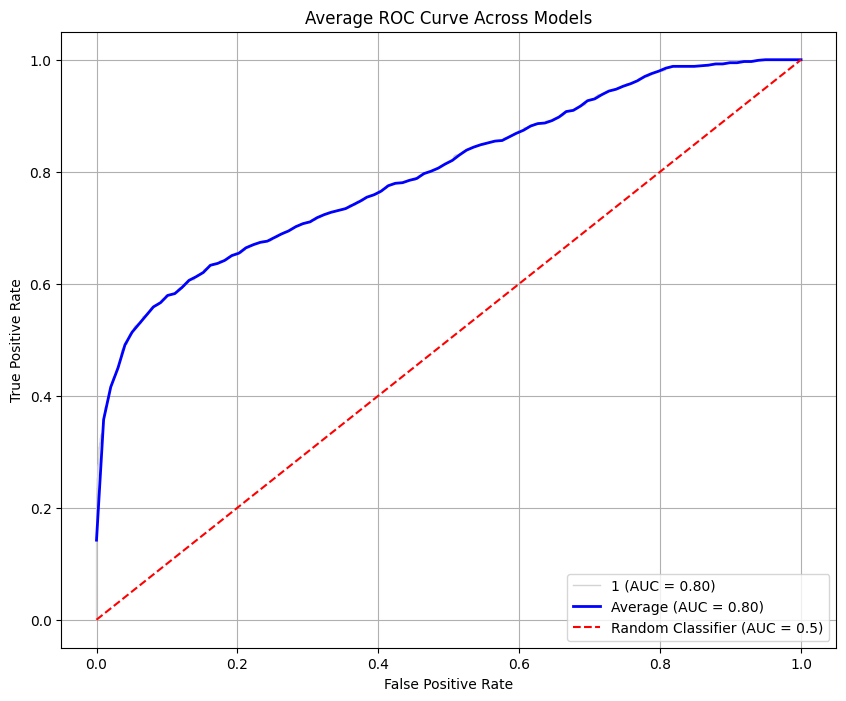

In [ ]:
my_models = [best_googlenet]
for model in my_models:
    model = model.to(device)
labels = ["best googlenet"]

plot_average_roc(my_models, test_loader, device, labels)

## Results per wall

### Getting Latex tables

In [ ]:
df1 = calculate_rates_by_wall(best_googlenet, train_loader, device, criterion, show_recall=True)
print(df1.to_latex(index=False))

\begin{tabular}{lrrrrrrrrrr}
\toprule
Wall & Num Samples & TP Rate & FP Rate & FN Rate & TN Rate & Loss & F1 Score & Accuracy & % Contribution to Global Loss & Recall \\
\midrule
0 & 106 & 0.000000 & 0.000000 & 0.000000 & 1.000000 & 0.015317 & NaN & 1.000000 & 0.019201 & NaN \\
1 & 445 & 0.000000 & 0.000000 & 0.000000 & 1.000000 & 0.001011 & NaN & 1.000000 & 0.005319 & NaN \\
10 & 292 & 0.000000 & 0.000000 & 0.000000 & 1.000000 & 0.004377 & NaN & 1.000000 & 0.015116 & NaN \\
11 & 17 & 0.000000 & 0.000000 & 0.000000 & 1.000000 & 0.004109 & NaN & 1.000000 & 0.000826 & NaN \\
120 & 12 & 0.000000 & 0.000000 & 0.000000 & 1.000000 & 0.001769 & NaN & 1.000000 & 0.000251 & NaN \\
121 & 16 & 0.000000 & 0.000000 & 0.000000 & 1.000000 & 0.001341 & NaN & 1.000000 & 0.000254 & NaN \\
123 & 19 & 0.000000 & 0.000000 & 0.000000 & 1.000000 & 0.001221 & NaN & 1.000000 & 0.000274 & NaN \\
126 & 636 & 0.182390 & 0.000000 & 0.205975 & 0.611635 & 0.529713 & 0.639118 & 0.794025 & 3.984162 & 0.469636 \\
133 &

In [ ]:
df2 = calculate_rates_by_wall(best_googlenet, val_loader, device, criterion, show_recall=True)
print(df2.to_latex(index=False))

\begin{tabular}{lrrrrrrrrrr}
\toprule
Wall & Num Samples & TP Rate & FP Rate & FN Rate & TN Rate & Loss & F1 Score & Accuracy & % Contribution to Global Loss & Recall \\
\midrule
272 & 495 & 0.117172 & 0.000000 & 0.068687 & 0.814141 & 0.164674 & 0.773333 & 0.931313 & 4.293100 & 0.630435 \\
273 & 1151 & 0.003475 & 0.004344 & 0.002606 & 0.989574 & 0.055362 & 0.500000 & 0.993050 & 3.356073 & 0.571429 \\
47 & 2175 & 0.000000 & 0.000000 & 0.000000 & 1.000000 & 0.001765 & NaN & 1.000000 & 0.202154 & NaN \\
6 & 5544 & 0.121392 & 0.025974 & 0.079365 & 0.773268 & 0.298918 & 0.697409 & 0.894661 & 87.280460 & 0.604672 \\
630 & 448 & 0.000000 & 0.000000 & 0.004464 & 0.995536 & 0.043341 & 0.000000 & 0.995536 & 1.022635 & 0.000000 \\
820 & 414 & 0.053140 & 0.014493 & 0.038647 & 0.893720 & 0.146438 & 0.666667 & 0.946860 & 3.192973 & 0.578947 \\
\bottomrule
\end{tabular}



In [ ]:
df3 = calculate_rates_by_wall(best_googlenet, test_loader, device, criterion, show_recall=True)
print(df3.to_latex(index=False))

\begin{tabular}{lrrrrrrrrrr}
\toprule
Wall & Num Samples & TP Rate & FP Rate & FN Rate & TN Rate & Loss & F1 Score & Accuracy & % Contribution to Global Loss & Recall \\
\midrule
104 & 877 & 0.003421 & 0.000000 & 0.023945 & 0.972634 & 0.108200 & 0.222222 & 0.976055 & 3.339303 & 0.125000 \\
195 & 1374 & 0.016739 & 0.000000 & 0.087336 & 0.895924 & 0.274653 & 0.277108 & 0.912664 & 13.280025 & 0.160839 \\
21 & 70 & 0.000000 & 0.000000 & 0.000000 & 1.000000 & 0.003493 & NaN & 1.000000 & 0.008603 & NaN \\
230 & 221 & 0.420814 & 0.000000 & 0.248869 & 0.330317 & 0.553482 & 0.771784 & 0.751131 & 4.304512 & 0.628378 \\
631 & 454 & 0.002203 & 0.000000 & 0.460352 & 0.537445 & 2.420964 & 0.009479 & 0.539648 & 38.678778 & 0.004762 \\
773 & 779 & 0.102696 & 0.001284 & 0.243902 & 0.652118 & 0.801998 & 0.455840 & 0.754814 & 21.985639 & 0.296296 \\
796 & 1614 & 0.000000 & 0.000000 & 0.007435 & 0.992565 & 0.055071 & 0.000000 & 0.992565 & 3.127893 & 0.000000 \\
816 & 65 & 0.000000 & 0.000000 & 0.030769 & 

### Displaying the tables

In [ ]:
df1

Wall  Num Samples   TP Rate   FP Rate   FN Rate   TN Rate      Loss  \
0     0          106  0.000000  0.000000  0.000000  1.000000  0.015317   
14    1          445  0.000000  0.000000  0.000000  1.000000  0.001011   
1    10          292  0.000000  0.000000  0.000000  1.000000  0.004377   
2    11           17  0.000000  0.000000  0.000000  1.000000  0.004109   
3   120           12  0.000000  0.000000  0.000000  1.000000  0.001769   
4   121           16  0.000000  0.000000  0.000000  1.000000  0.001341   
5   123           19  0.000000  0.000000  0.000000  1.000000  0.001221   
6   126          636  0.182390  0.000000  0.205975  0.611635  0.529713   
7   133         1348  0.000000  0.000000  0.000742  0.999258  0.008017   
11   18            4  0.000000  0.000000  0.000000  1.000000  0.002345   
8   184          200  0.025000  0.000000  0.160000  0.815000  0.398058   
9   188          442  0.002262  0.000000  0.140271  0.857466  0.564742   
10  189         1476  0.007453  0.000000  0.091463  0.901084  0.312101   
12  194          654  0.128440  0.000000  0.126911  0.744648  0.295148   
13  196          252  0.000000  0.000000  0.000000  1.000000  0.009769   
15  235          168  0.000000  0.000000  0.000000  1.000000  0.010100   
16  243          725  0.000000  0.000000  0.006897  0.993103  0.037304   
17  251          174  0.097701  0.000000  0.068966  0.833333  0.172692   
18  255         2327  0.000000  0.000000  0.036098  0.963902  0.143170   
19  279        18626  0.001020  0.000107  0.030280  0.968592  0.111226   
20  281         3380  0.000000  0.000000  0.013314  0.986686  0.068912   
21  286          891  0.000000  0.000000  0.006734  0.993266  0.038939   
22   34          179  0.000000  0.000000  0.000000  1.000000  0.009414   
23   42          775  0.000000  0.000000  0.000000  1.000000  0.020567   
24   43           17  0.000000  0.000000  0.000000  1.000000  0.002394   
26    5         2418  0.211745  0.001654  0.316791  0.469810  0.714885   
25   55         2002  0.000999  0.000000  0.002997  0.996004  0.018389   
30    7         5273  0.393135  0.003224  0.077944  0.525697  0.188531   
27  739          465  0.000000  0.000000  0.000000  1.000000  0.001402   
28  756          459  0.000000  0.000000  0.028322  0.971678  0.090483   
29  775          892  0.000000  0.000000  0.000000  1.000000  0.001258   
34    8           62  0.000000  0.000000  0.000000  1.000000  0.003689   
31  815         2404  0.000000  0.000000  0.002496  0.997504  0.015978   
32  817          324  0.000000  0.000000  0.009259  0.990741  0.032704   
33  821          452  0.210177  0.000000  0.245575  0.544248  0.545858   

    F1 Score  Accuracy  % Contribution to Global Loss    Recall  
0        NaN  1.000000                       0.019201       NaN  
14       NaN  1.000000                       0.005319       NaN  
1        NaN  1.000000                       0.015116       NaN  
2        NaN  1.000000                       0.000826       NaN  
3        NaN  1.000000                       0.000251       NaN  
4        NaN  1.000000                       0.000254       NaN  
5        NaN  1.000000                       0.000274       NaN  
6   0.639118  0.794025                       3.984162  0.469636  
7   0.000000  0.999258                       0.127801  0.000000  
11       NaN  1.000000                       0.000111       NaN  
8   0.238095  0.840000                       0.941489  0.135135  
9   0.031250  0.859729                       2.951966  0.015873  
10  0.140127  0.908537                       5.447797  0.075342  
12  0.669323  0.873089                       2.282737  0.502994  
13       NaN  1.000000                       0.029113       NaN  
15       NaN  1.000000                       0.020066       NaN  
16  0.000000  0.993103                       0.319836  0.000000  
17  0.739130  0.931034                       0.355353  0.586207  
18  0.000000  0.963902                       3.939926  0.000000  
19  0.062914  0.96

In [ ]:
df2

Wall  Num Samples   TP Rate   FP Rate   FN Rate   TN Rate      Loss  \
0  272          495  0.117172  0.000000  0.068687  0.814141  0.164674   
1  273         1151  0.003475  0.004344  0.002606  0.989574  0.055362   
2   47         2175  0.000000  0.000000  0.000000  1.000000  0.001765   
4    6         5544  0.121392  0.025974  0.079365  0.773268  0.298918   
3  630          448  0.000000  0.000000  0.004464  0.995536  0.043341   
5  820          414  0.053140  0.014493  0.038647  0.893720  0.146438   

   F1 Score  Accuracy  % Contribution to Global Loss    Recall  
0  0.773333  0.931313                       4.293100  0.630435  
1  0.500000  0.993050                       3.356073  0.571429  
2       NaN  1.000000                       0.202154       NaN  
4  0.697409  0.894661                      87.280460  0.604672  
3  0.000000  0.995536                       1.022635  0.000000  
5  0.666667  0.946860                       3.192973  0.578947

In [ ]:
df3

Wall  Num Samples   TP Rate   FP Rate   FN Rate   TN Rate      Loss  \
0  104          877  0.003421  0.000000  0.023945  0.972634  0.108200   
1  195         1374  0.016739  0.000000  0.087336  0.895924  0.274653   
2   21           70  0.000000  0.000000  0.000000  1.000000  0.003493   
3  230          221  0.420814  0.000000  0.248869  0.330317  0.553482   
4  631          454  0.002203  0.000000  0.460352  0.537445  2.420964   
5  773          779  0.102696  0.001284  0.243902  0.652118  0.801998   
6  796         1614  0.000000  0.000000  0.007435  0.992565  0.055071   
7  816           65  0.000000  0.000000  0.030769  0.969231  0.197909   
8    9           36  0.000000  0.000000  0.250000  0.750000  0.901588   

   F1 Score  Accuracy  % Contribution to Global Loss    Recall  
0  0.222222  0.976055                       3.339303  0.125000  
1  0.277108  0.912664                      13.280025  0.160839  
2       NaN  1.000000                       0.008603       NaN  
3  0.771784  0.751131                       4.304512  0.628378  
4  0.009479  0.539648                      38.678778  0.004762  
5  0.455840  0.754814                      21.985639  0.296296  
6  0.000000  0.992565                       3.127893  0.000000  
7  0.000000  0.969231                       0.452696  0.000000  
8  0.000000  0.750000                       1.142192  0.000000

### Walls with higher loss contribution

Looking at the results, the highest contribution to the loss come from wall 279 and 5 (train), wall 6 (val), and wall 631 and 773 (test). We can try to see if they share common features (images with red borders are misclassified):

Found 18626 images for Wall 279.


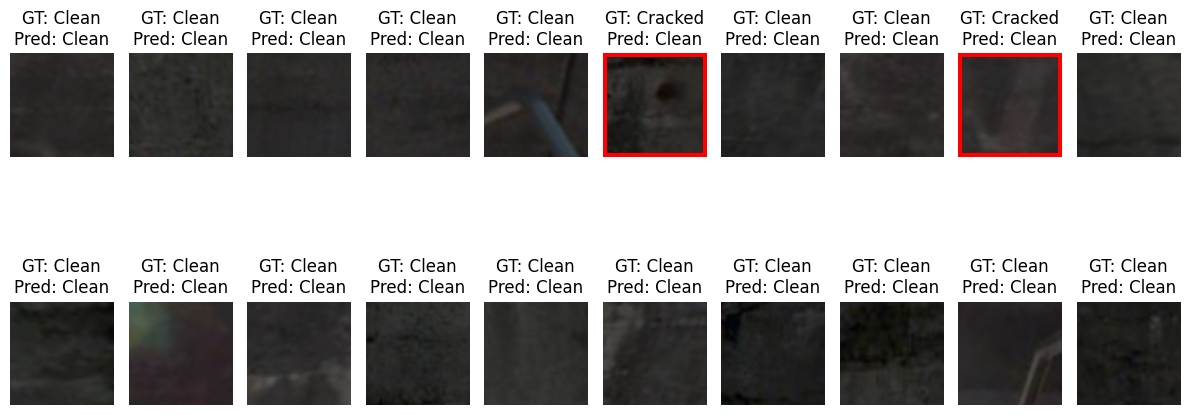

In [ ]:
display_wall_images(train_dataset, '/content/dataset/train', best_googlenet, device, 279, num_samples=20)

Found 2418 images for Wall 5.


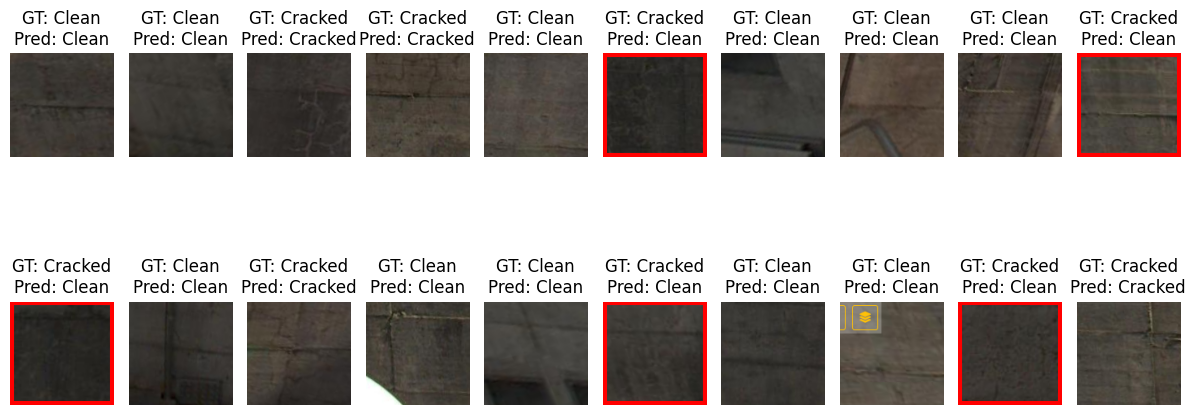

In [ ]:
display_wall_images(train_dataset, '/content/dataset/train', best_googlenet, device, 5, num_samples=20)

Found 5544 images for Wall 6.


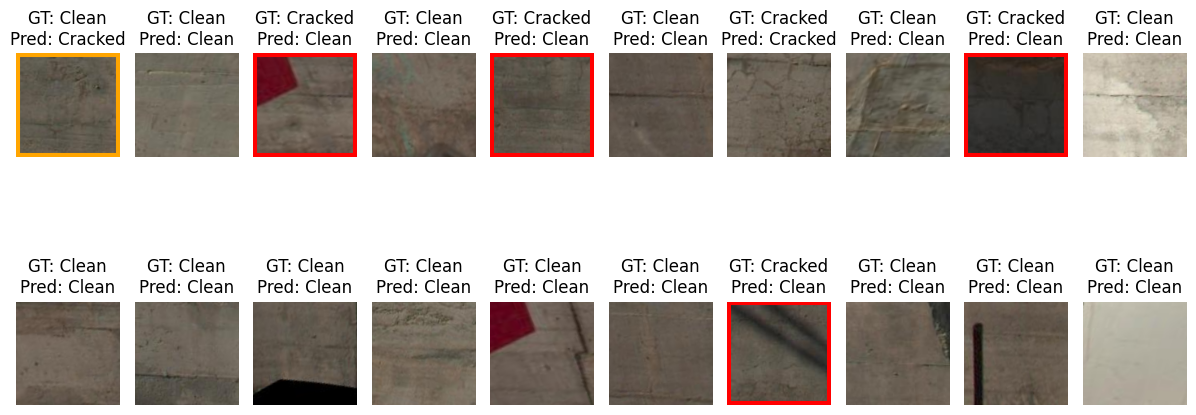

In [ ]:
display_wall_images(train_dataset, '/content/dataset/validation', best_googlenet, device, 6, num_samples=20)

Found 454 images for Wall 631.


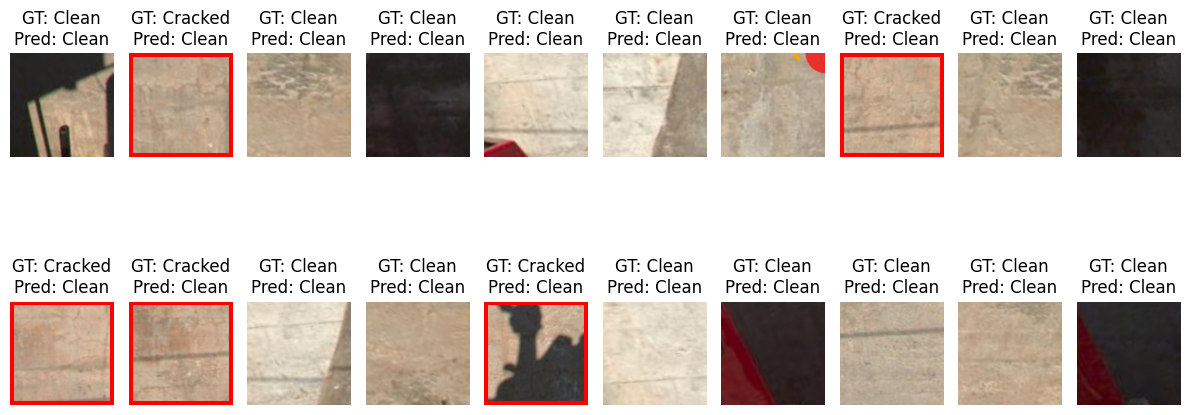

In [ ]:
display_wall_images(train_dataset, '/content/dataset/test', best_googlenet, device, 631, num_samples=20)

Found 779 images for Wall 773.


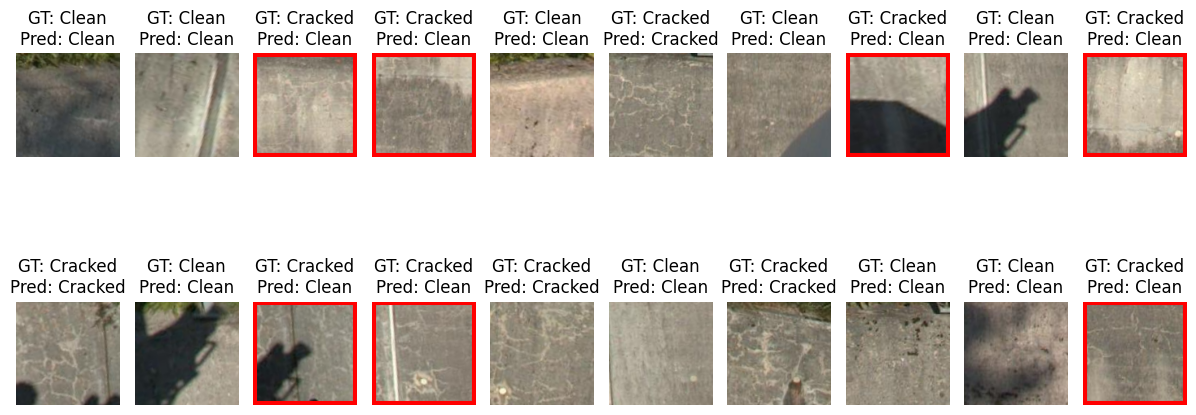

In [ ]:
display_wall_images(train_dataset, '/content/dataset/test', best_googlenet, device, 773, num_samples=20)

By observing these 5 sets of images, some general deduction can be made: first, some cracks are objectively hard to detect, and tricky because of the image quality. Second, the presence of cracks in darker images can easily go unnoticed (see walls 279, 5, 6).

Therefore, improving the image quality could be beneficial. We could also try more drastic plays on the brightness in the data augmentation. Lastly, it seems natural that for real case applications, some guidelines on the required luminosity level should be set: for example, the pictures should be taken with a flash.

### Walls with highest FN

In our crack detection task for safety monitoring, avoiding False Negatives is the priority. However, 2 walls have very concerning FN rates: wall 631 (46% of total predictions) and wall 5 (32% percent of total predictions)

Found 2418 images for Wall 5.


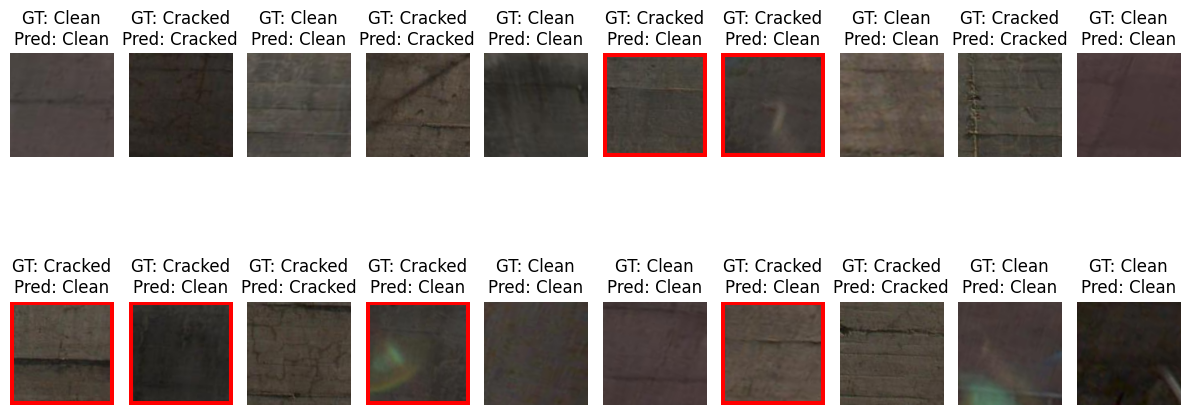

In [ ]:
display_wall_images(train_dataset, '/content/dataset/train', best_googlenet, device, 5, num_samples=20)

Found 454 images for Wall 631.


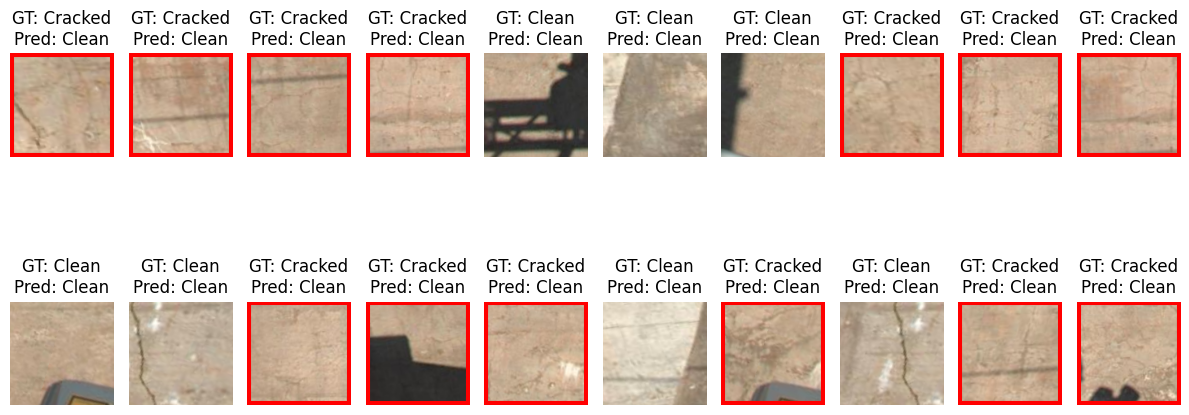

In [ ]:
display_wall_images(train_dataset, '/content/dataset/test', best_googlenet, device, 631, num_samples=20)

### Walls with highest FN: prediction plots using XAI

We decide to use the gradient method, as it showed the most interesting results. We apply it to the walls from the previous part:

Found 2418 images for Wall 5.


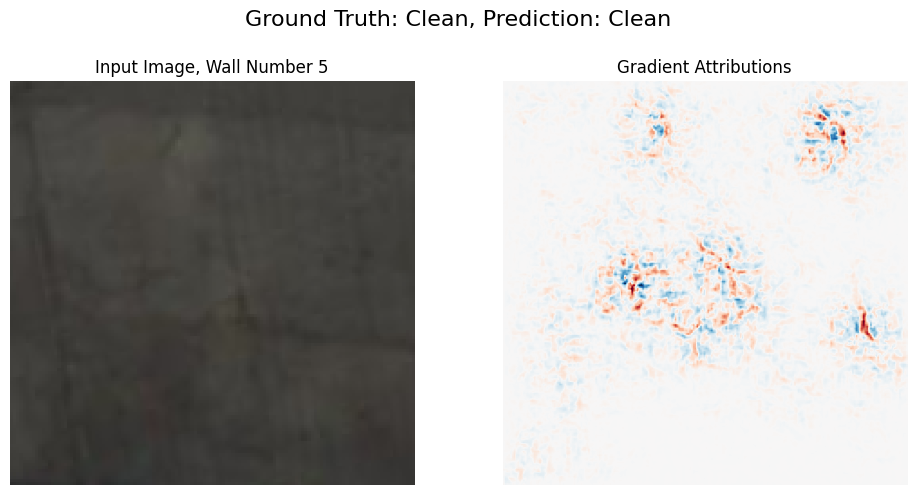

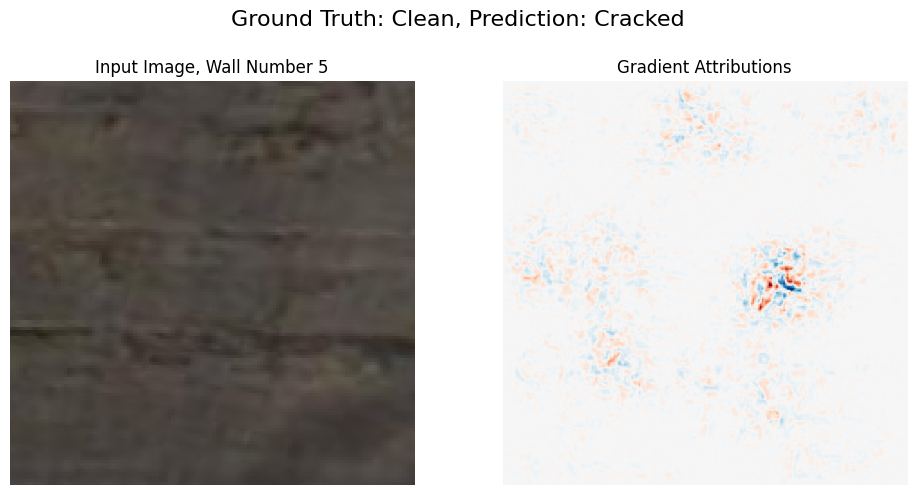

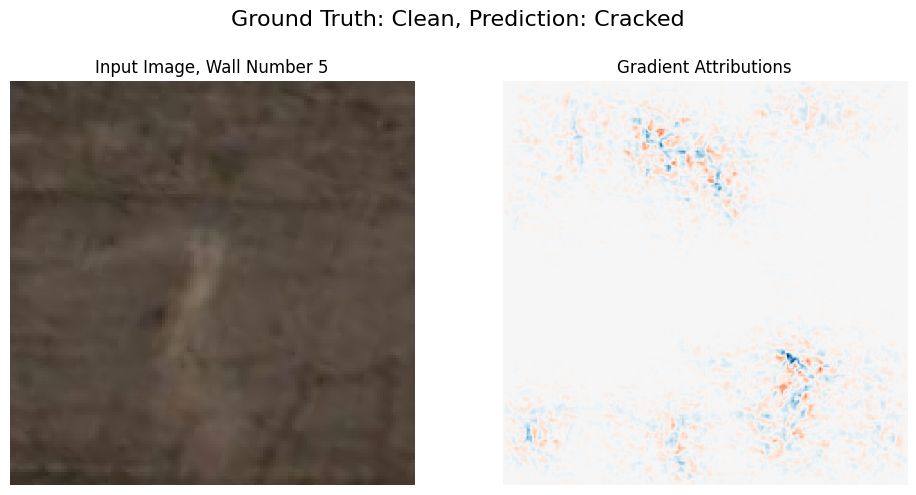

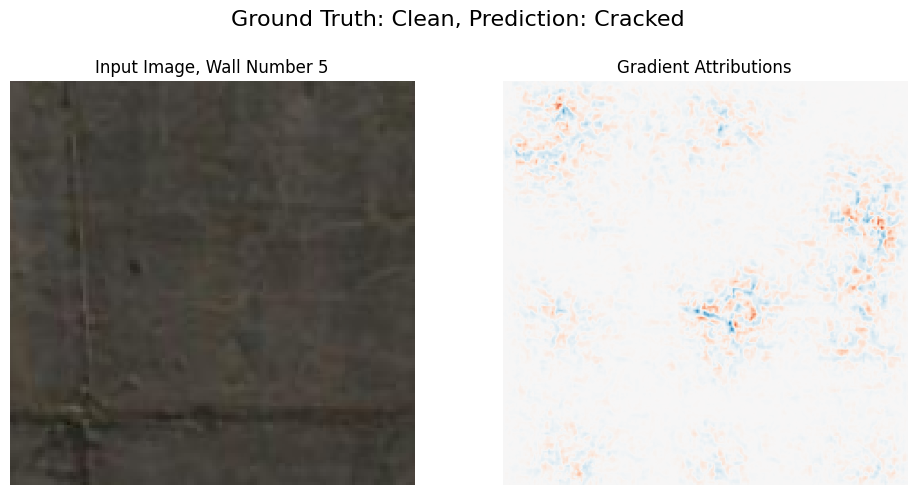

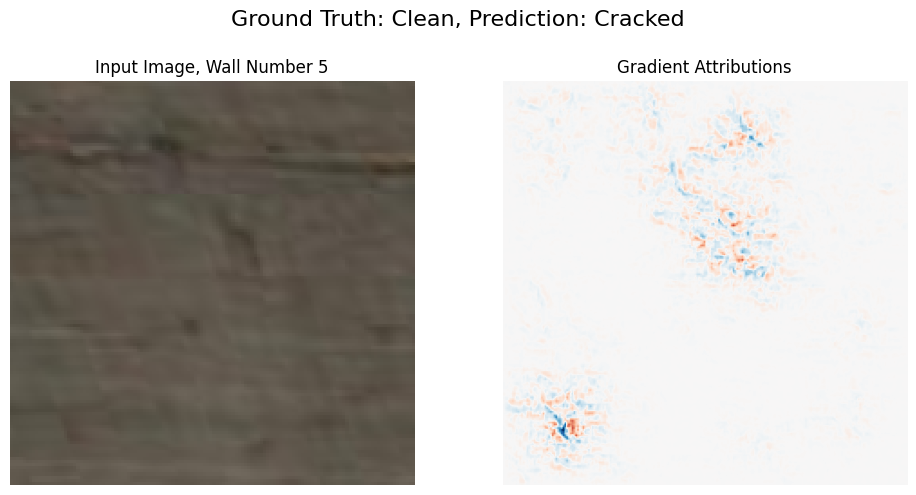

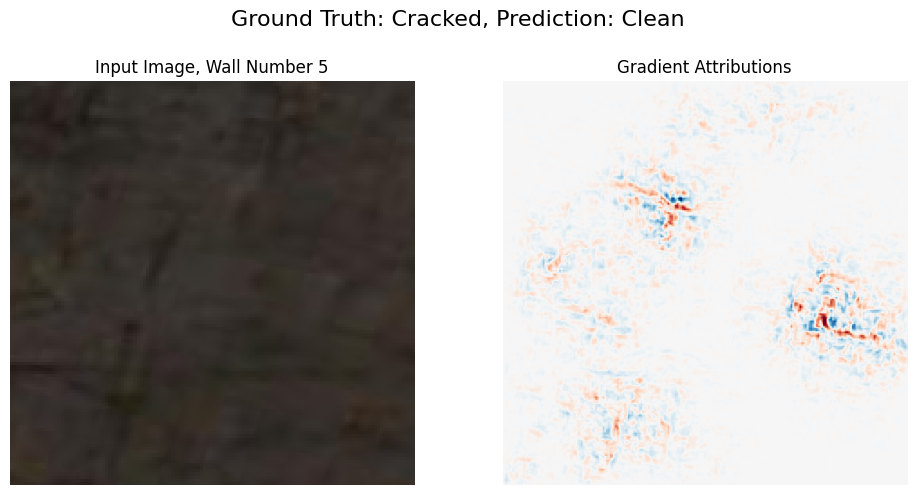

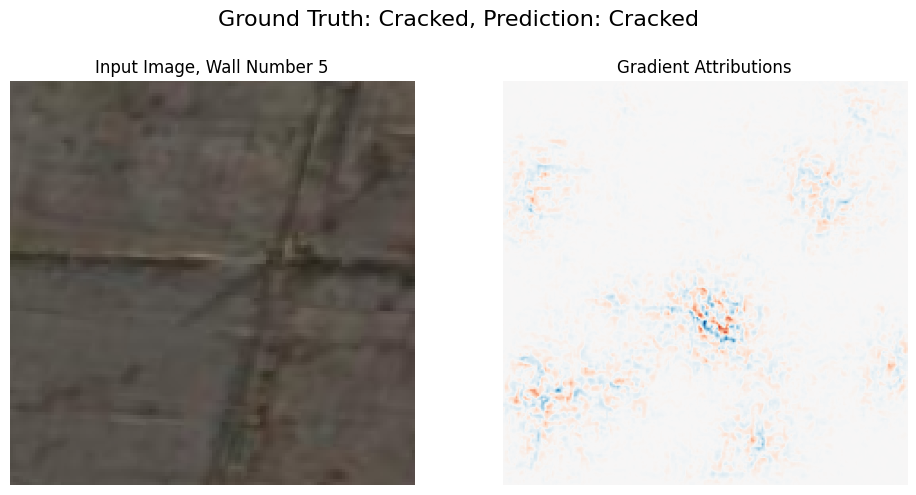

Visualization for Wall 5 completed.


In [ ]:
visualize_wall_images(train_dataset, '/content/dataset/train', best_googlenet, device, wall_number=5, method='gradient', w=4, save=False)

Found 454 images for Wall 631.


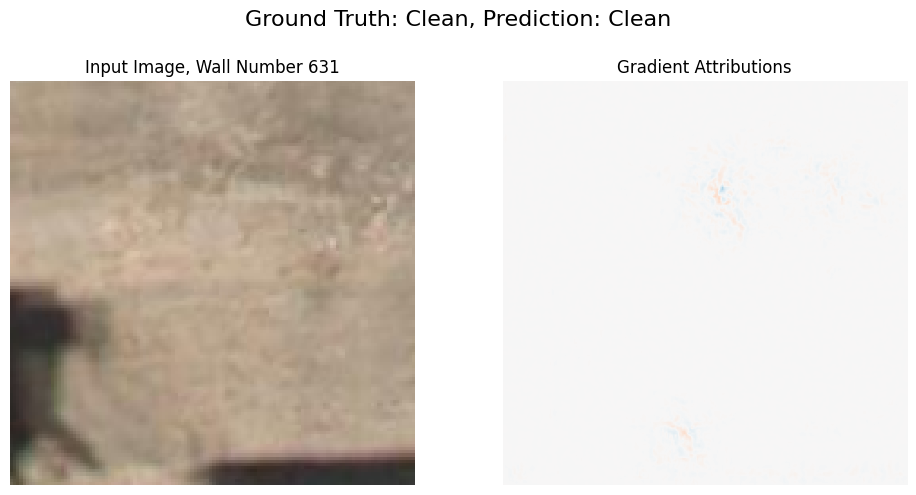

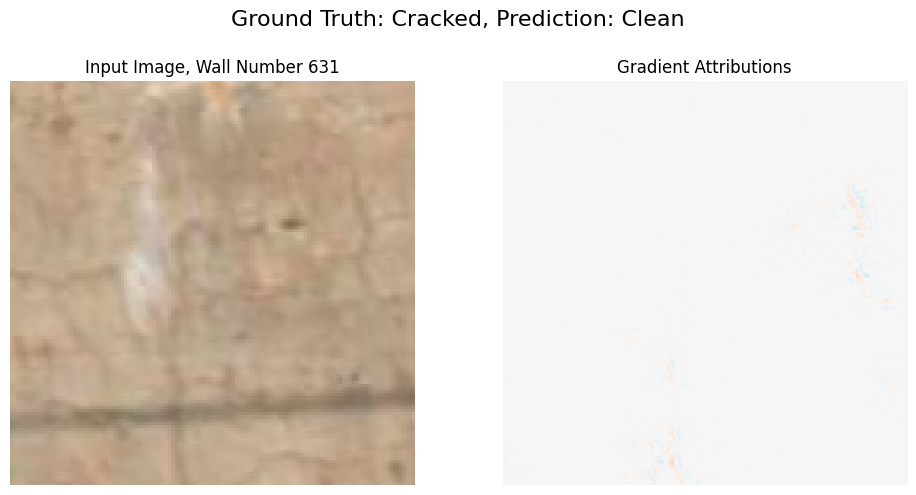

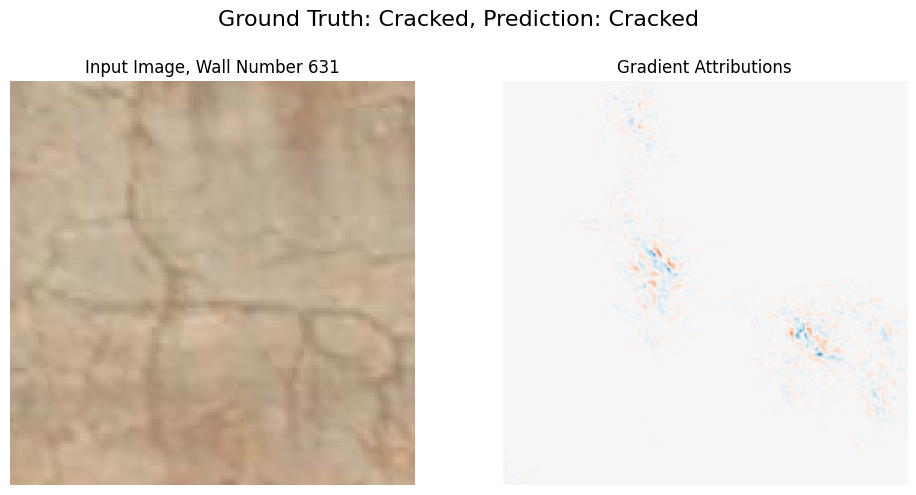

Visualization for Wall 631 completed.


In [ ]:
visualize_wall_images(train_dataset, '/content/dataset/test', best_googlenet, device, wall_number=631, method='gradient', w=4, save=False)

The model does not blantatly misses obvious information from the images. There are some parts that could easily be mistaken by cracks, and others that are a lot harder to detect. In wall 631's FN, there is some activation where the crack is located, but not enough for the right prediction.

This is more likely a question of image quality and tricky cracks that are hardly visible.

### Extra: variance in training discussion

We strongly faced the problem of variability in the training. We import another model (the final one from the training of the best model, which is not the best model across epochs) and look in the dataset where the differences arise from:

In [ ]:
comp_model = models.googlenet(weights="IMAGENET1K_V1")
comp_model.fc = nn.Linear(comp_model.fc.in_features, 2)
comp_model.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Model_weights/Step_4_Hyperparameter_tuning/Nathan/cosine/GoogLeNet_trial_1.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
evaluate_model_metrics(comp_model, device, criterion, train_loader)

{'accuracy': 97.21226984461518,
 'f1_score': 0.9709755414001806,
 'auc': 0.9779897586391707,
 'average_loss': 0.09332487912668035}

In [ ]:
evaluate_model_metrics(comp_model, device, criterion, val_loader)

{'accuracy': 92.85581740582668,
 'f1_score': 0.9277933704044347,
 'auc': 0.9159111116104638,
 'average_loss': 0.22416643234520708}

In [ ]:
evaluate_model_metrics(comp_model, device, criterion, test_loader)

{'accuracy': 90.8974358974359,
 'f1_score': 0.9025403238572065,
 'auc': 0.8341375695558344,
 'average_loss': 0.3612070482733516}

Interestingly, we notice the validation results get worse but some test metrics get better.

Let's inspect from what walls the difference arises.

In [ ]:
calculate_rates_by_wall(comp_model, val_loader, device, criterion)

Wall  Num Samples   TP Rate   FP Rate   FN Rate   TN Rate      Loss  \
0  272          495  0.101010  0.002020  0.084848  0.812121  0.236071   
1  273         1151  0.003475  0.028671  0.002606  0.965248  0.087561   
2   47         2175  0.000000  0.000000  0.000000  1.000000  0.000403   
4    6         5544  0.136364  0.050505  0.064394  0.748737  0.362601   
3  630          448  0.000000  0.026786  0.004464  0.968750  0.110923   
5  820          414  0.065217  0.031401  0.026570  0.876812  0.158433   

   F1 Score  Accuracy  Percentage Contribution to Global Loss  
0  0.699301  0.913131                                4.842185  
1  0.181818  0.968723                                4.176180  
2       NaN  1.000000                                0.036303  
4  0.703583  0.885101                               83.300415  
3  0.000000  0.968750                                2.059174  
5  0.692308  0.942029                                2.717948

In [ ]:
calculate_rates_by_wall(comp_model, test_loader, device, criterion)

Wall  Num Samples   TP Rate   FP Rate   FN Rate   TN Rate      Loss  \
0  104          877  0.004561  0.042189  0.022805  0.930445  0.201933   
1  195         1374  0.072052  0.064047  0.032023  0.831878  0.296486   
2   21           70  0.000000  0.014286  0.000000  0.985714  0.029646   
3  230          221  0.488688  0.022624  0.180995  0.307692  0.446943   
4  631          454  0.033040  0.002203  0.429515  0.535242  2.078290   
5  773          779  0.177150  0.002567  0.169448  0.650834  0.703575   
6  796         1614  0.000000  0.000000  0.007435  0.992565  0.063512   
7  816           65  0.000000  0.000000  0.030769  0.969231  0.236624   
8    9           36  0.000000  0.000000  0.250000  0.750000  1.358804   

   F1 Score  Accuracy  Percentage Contribution to Global Loss  
0  0.123077  0.935006                                6.113649  
1  0.600000  0.903930                               14.063227  
2  0.000000  0.985714                                0.071640  
3  0.827586  0.796380                                3.409873  
4  0.132743  0.568282                               32.572862  
5  0.673171  0.827985                               18.920906  
6  0.000000  0.992565                                3.538802  
7  0.000000  0.969231                                0.530966  
8  0.000000  0.750000                                1.688704

The test F1 score increase likely comes from the augmentation of the F1 score in wall 195. However, the best model still has a lower validation loss for wall 192 than this comparison model.

Looking only at the loss (the metric we used for our best model decision, together with AUC), the performance of wall 47 (validation) and wall 773 (test) improve. However, the performance of wall 6 (validation) and wall 796 (test) decrease. We deliberately mention walls with higher number of samples as they impact training the most. Going further, it would be interesting to find what these walls may have in common.